In [1]:
from google.colab import files
from google.colab import drive
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
from torch.utils.data import Dataset, DataLoader
from skimage import io
from torch.autograd import Variable
from torchsummary import summary
from scipy.stats import zscore
import pandas as pd

In [2]:
uploaded = files.upload()

Saving calendar_tests.xlsx to calendar_tests.xlsx


In [3]:
table=pd.read_excel("calendar_tests.xlsx")

In [4]:
#keep only the columns that we'll use

col=["Sample","Storage temperature (°C)","Storage SOC","Storage time (Days)","C-Loss\n(%)"]
col_idx=[np.where([table.columns==col[i]])[1][0] for i in range(len(col))]
tmp=table.iloc[:,col_idx]

#removing null values
null_idx=np.where(tmp.isnull())[0]
not_null_idx=[i for i in range(tmp.shape[0]) if i not in null_idx ]
train_data=tmp.iloc[not_null_idx,:]

#group by sample and names
grouped=train_data.groupby("Sample")
names=list(grouped.groups.keys())
indexes=[grouped.get_group(name).index for name in names] #indexes of rows corresponding to each name

#converting string to int and converting to tensor 
tmp =[]
for i in range(train_data.shape[0]):
  tmp.append([int(train_data.iloc[:,1][i][:-2]),int(train_data.iloc[:,2][i][:-2])])

train_data=train_data.to_numpy()
train_data[:,1:3]=tmp

train_targets = torch.tensor(train_data[:,-1].tolist()).float()
train_data = torch.tensor(train_data[:,1:-1].tolist()).float()


In [6]:
class NN(nn.Module):
  def __init__(self, hidden_1 = 30, hidden_2 = 60,hidden_3=30):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(3,hidden_1)
    self.fc2 = nn.Linear(hidden_1,hidden_2)
    self.fc3 = nn.Linear(hidden_2,hidden_2)
    self.fc4 = nn.Linear(hidden_2,hidden_3)
    self.fc5 = nn.Linear(hidden_3,1)
    self.activ1 = nn.Sigmoid()
    self.activ2 = nn.ReLU()
   
  def forward(self,y):
    out = self.activ2(self.fc1(y))
    out = self.activ2(self.fc2(out))
    out = self.activ2(self.fc3(out))
    out = self.activ2(self.fc4(out))
    out = self.activ1(self.fc5(out))
    return out

Define custom loss

In [7]:
#compute derivative wtr to  sequence tensor x

def df(model, x = None, order = 1,var_idx = 2):
    """Compute neural network derivative with respect to the input feature(s) using PyTorch autograd engine"""
    df_value = model(x)[0]
    for j in range(order):
        df_value = torch.autograd.grad(
            df_value,x,
            create_graph=True,
            retain_graph=True,
        )[0][var_idx]
    return df_value



In [ ]:
#hyperparameters

lr=0.001
num_epochs=300
train = 1
load=0
gamma=0.6
step=200
beta=0.001
loss_weights=[3,0.0009,0.3,0] #[MSE loss, DE_loss, boundary_loss, constant_penalty]
sz = 50
#model/optim/loss func

model = NN()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr)
scheduler = optim.lr_scheduler.StepLR(optimizer,step,gamma)


# PATH='calendar.pt'
# state_dict = torch.load(PATH)
# model.load_state_dict(state_dict)


loss_hist=[]
if train :
  for epoch in range(num_epochs):
    boundary_loss,DE_loss,loss,constant_penalty=[],0,0,0
    y=model.forward(train_data)

    loss2=criterion(y,abs(train_targets))
    for i in range(len(names)):
      for j in indexes[i]:

        inp=train_data[j,:].requires_grad_(True)
        out=y[j]
        loss+= criterion(out,abs(train_targets)[j])
        a=torch.tensor(np.random.rand(sz,2))
        a=torch.cat((a,torch.zeros(sz,1)),1)
        boundary_loss.append(abs(model(a.float())).max().detach().numpy())
        der=[df(model,inp,1),df(model,inp,2)]
        constant_penalty+=abs(der[0])
        if inp[2]!=0:
          
          DE_loss += abs(der[1]+der[0]/(2*inp[2]))  #has trivial solution, dc/dt=0, dc2/dt2=0 we add a regularization term
          if der[0]<0:
            DE_loss+=1
        else:
          DE_loss+=20*abs(out.item())

    constant_penalty=len(train_targets)/constant_penalty
    boundary_loss=np.max(boundary_loss)
    DE_loss =DE_loss/len(train_targets)
    loss=loss/len(train_targets)
    loss=loss_weights[0]*loss+ loss_weights[1]*DE_loss + loss_weights[2]*boundary_loss + loss_weights[3]*constant_penalty
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    loss_hist.append([loss2.data, DE_loss.data, boundary_loss, constant_penalty.data, loss.data])
    print('epoch [{}/{}], MSE loss:{:.4f}, Diff equ loss:{:.4f}, Boundary loss:{:.4f}, constant penalty:{:.4f}, training loss {:.4f} '
           .format(epoch + 1, num_epochs, loss2.data, DE_loss, boundary_loss, constant_penalty, loss.data))
    #print(model.fc1.weight.grad)
    # for each sample compute gradients sum losses over samples 


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([182])) that is different to the input size (torch.Size([182, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch [1/300], MSE loss:0.4529, Diff equ loss:1.7399, Boundary loss:0.5133, constant penalty:952.3927, training loss 1.5143 
epoch [2/300], MSE loss:0.4495, Diff equ loss:1.8826, Boundary loss:0.5102, constant penalty:693.2907, training loss 1.5031 
epoch [3/300], MSE loss:0.4460, Diff equ loss:1.9538, Boundary loss:0.5072, constant penalty:494.8402, training loss 1.4919 
epoch [4/300], MSE loss:0.4425, Diff equ loss:2.0030, Boundary loss:0.5042, constant penalty:360.3937, training loss 1.4806 
epoch [5/300], MSE loss:0.4390, Diff equ loss:1.9981, Boundary loss:0.5013, constant penalty:288.1546, training loss 1.4691 
epoch [6/300], MSE loss:0.4353, Diff equ loss:1.9938, Boundary loss:0.4983, constant penalty:229.2495, training loss 1.4573 


In [19]:
#save 

torch.save(model.state_dict(),"model_save.ckpt")

#load
state_dictio = torch.load("model_save.ckpt")

model.load_state_dict(state_dictio)



<All keys matched successfully>

MEAN ABSOLUTE ERROR: 0.6206312216818333 % 





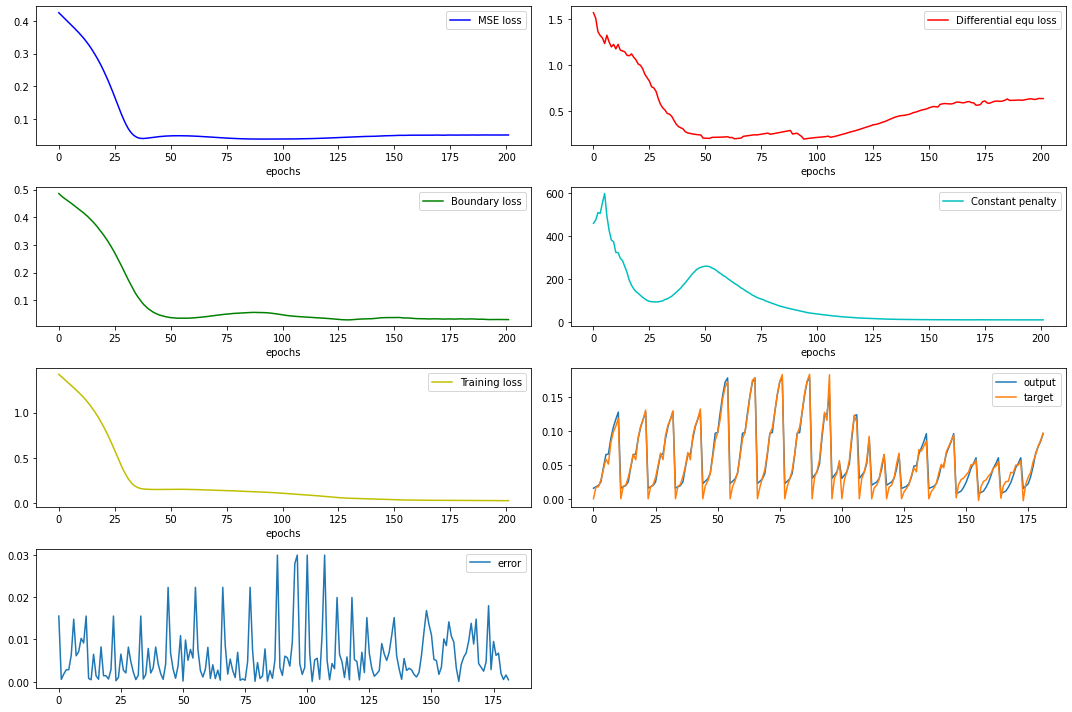

In [20]:
#evaluate error wtr to a condition

out = model(train_data)
err=abs(train_targets.detach().unsqueeze(1)-out.detach())
print("MEAN ABSOLUTE ERROR:",100*err.mean().item(),"% \n\n\n" )
labels=['MSE loss', 'Differential equ loss', 'Boundary loss', 'Constant penalty', 'Training loss']


fig=plt.figure(figsize=(15,10))

plt.subplot(421)
plt.plot(np.array(loss_hist)[:,0],'b',label=labels[0])
plt.legend()
plt.xlabel("epochs")


plt.subplot(422)
plt.plot(np.array(loss_hist)[:,1],'r',label=labels[1])
plt.legend()
plt.xlabel("epochs")

plt.subplot(423)
plt.plot(np.array(loss_hist)[:,2],'g',label=labels[2])
plt.legend()
plt.xlabel("epochs")

plt.subplot(424)
plt.plot(np.array(loss_hist)[:,3],'c',label=labels[3])
plt.xlabel("epochs")
plt.legend()

plt.subplot(425)
plt.plot(np.array(loss_hist)[:,4],'y',label=labels[4])
plt.legend()
plt.xlabel("epochs")

# ax[2,0]=
plt.subplot(426)
plt.plot(range(len(err)),out.detach().numpy(),label="output")
plt.plot(range(len(err)),train_targets.detach().numpy(),label="target")
plt.legend()




plt.subplot(427)
plt.plot(err,label="error")
plt.legend()

fig.tight_layout() 




Text(0, 0.5, 'predictions')

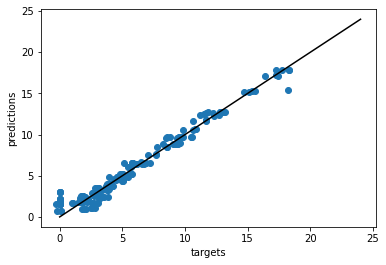

In [21]:
plt.scatter(100*train_targets.detach().unsqueeze(1),100*out.detach())
plt.plot(range(25),range(25),'k')
plt.xlabel("targets")
plt.ylabel("predictions")

torch.Size([3, 1, 20, 200])
(20, 200)


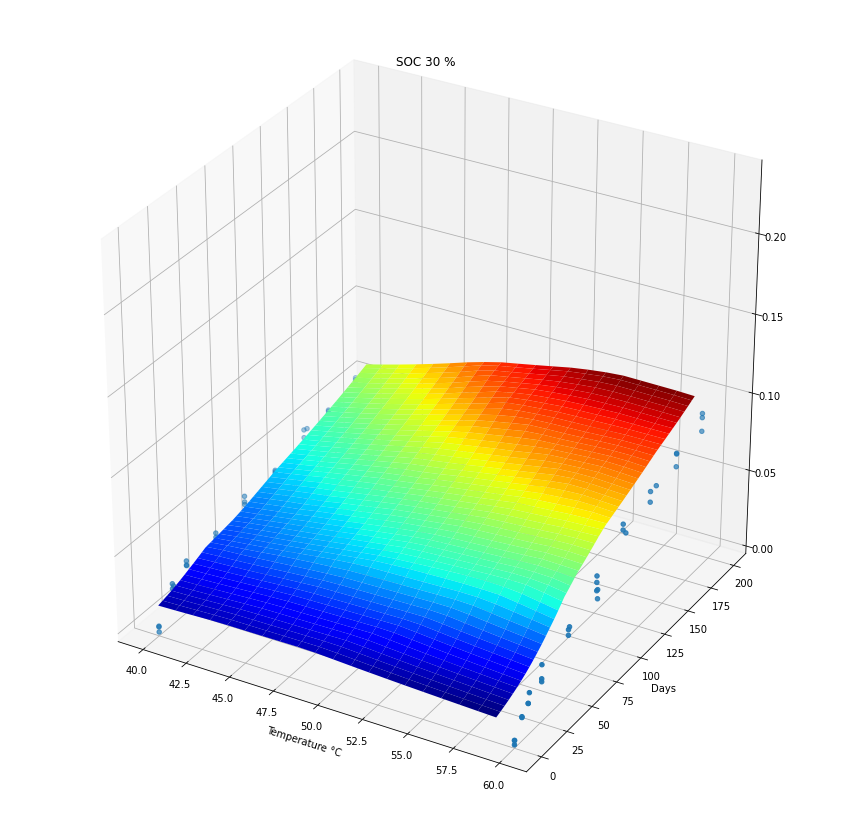

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm

SOCs=[30] #np.linspace(20,100,81)
pts=train_data*(max-min)+min
for SOC in SOCs:
  idx=np.where([pts[:,1].numpy()==SOC])[1]

  X = np.arange(40, 60, 1)
  Y = np.arange(0, 200, 1)
  coord_orig=torch.tensor(np.meshgrid(X,SOC, Y))
  print(np.shape(coord_orig))
  coord=(coord_orig.permute(0,3,2,1).reshape(3,-1).permute(1,0)-min)/(max-min)
  out=model.eval()(coord.float()).permute(0,1).reshape(1,200,20,-1).permute(0,3,2,1).squeeze().detach().numpy()
  print(out.shape)
  # 3D Projection

  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(111, projection='3d')

  ax.plot_surface(coord_orig[0].squeeze(),coord_orig[2].squeeze(),out,cmap=cm.jet)
  ax.scatter3D(pts[idx,0],pts[idx,2],train_targets[idx])
  ax.set_zlim(0,0.24)
  plt.title("SOC " + str(SOC) + " %")
  plt.xlabel("Temperature °C")
  plt.ylabel("Days")

  # fig.savefig('/content/imgs/'+str(SOC)+'.jpg', bbox_inches='tight', dpi=150)

Video visualization

In [22]:
import cv2
import numpy as np
import os
from os.path import isfile, join

def first3chars(x):
    return(x[:4])


def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    #for sorting the file names properly
    files=sorted(files, key = first3chars) 
    tmp=files[0]
    files=files[1:]
    files.append(tmp)
    print(files)
    for i in range(len(files)):
        filename=os.path.join(pathIn , files[i])
        print(filename)
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)

        #inserting the frames into an image array
        frame_array.append(img)
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [23]:
# convert_frames_to_video("/content/deriv",'video_deriv.avi',25)

FileNotFoundError: ignored